# 隐马尔可夫模型

## 安装 Graphviz


1. 安装graphviz  

 - 安装文件下载地址：https://graphviz.gitlab.io/_pages/Download/Download_windows.html
 - 安装过程中选择将graphviz加到PATH

2. 安装python插件graphviz： pip install graphviz

3. 安装python插件pydotplus：pip install pydotplus

## 绘制流程图

In [2]:
import numpy as np
from collections import Counter
import logging
logging.basicConfig(level=logging.DEBUG,format='%(asctime)s - [line:%(lineno)d] - %(levelname)s: %(message)s')

In [3]:
states = ('Healthy', 'Fever')
start_probability = {'Healthy': 0.6, 'Fever': 0.4}
transition_probability = {
    'Healthy': {'Healthy': 0.7, 'Fever': 0.3},
    'Fever': {'Healthy': 0.4, 'Fever': 0.6},
}
emission_probability = {
    'Healthy': {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
    'Fever': {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
}
observations = ('normal', 'cold', 'dizzy')

2021-04-08 14:53:21,809 - [line:153] - DEBUG: run ['dot', '-Kdot', '-Tsvg']


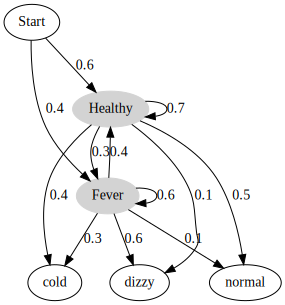

In [4]:
from graphviz import *

g = Digraph()

g.node("Start")

for key in transition_probability:
    g.node(key, style='filled', color="lightgray")
    
for key in emission_probability['Healthy']:
    g.node(key)

for key in start_probability:
    g.edge("Start",key, label=str(start_probability[key]))
    
for key in transition_probability:
    for state in transition_probability[key]:
        g.edge(key, state, label=str(transition_probability[key][state]))

for key in emission_probability:
    for observation in emission_probability[key]:
        g.edge(key, observation, label=str(emission_probability[key][observation]))
        
g

## 数据转换

In [6]:
def generate_index_map(lables):
    index_label = {}
    label_index = {}
    i = 0
    for l in lables:
        index_label[i] = l
        label_index[l] = i
        i += 1
    return label_index, index_label

In [7]:
states_label_index, states_index_label = generate_index_map(states)
observations_label_index, observations_index_label = generate_index_map(observations)

In [6]:
 observations_index_label

{0: 'normal', 1: 'cold', 2: 'dizzy'}

In [7]:
states_label_index

{'Healthy': 0, 'Fever': 1}

In [8]:
states_index_label

{0: 'Healthy', 1: 'Fever'}

In [9]:
def convert_observations_to_index(observations, label_index):
    list = []
    for o in observations:
        list.append(label_index[o])
    return list


def convert_map_to_vector(map, label_index):
    v = np.empty(len(map), dtype=float)
    for e in map:
        v[label_index[e]] = map[e]
    return v


def convert_map_to_matrix(map, label_index1, label_index2):
    m = np.empty((len(label_index1), len(label_index2)), dtype=float)
    for line in map:
        for col in map[line]:
            m[label_index1[line]][label_index2[col]] = map[line][col]
    return m

In [10]:
A = convert_map_to_matrix(transition_probability, states_label_index, states_label_index)
B = convert_map_to_matrix(emission_probability, states_label_index, observations_label_index)
observations_index = convert_observations_to_index(observations, observations_label_index)
pi = convert_map_to_vector(start_probability, states_label_index)

In [11]:
A

array([[0.7, 0.3],
       [0.4, 0.6]])

In [12]:
B

array([[0.5, 0.4, 0.1],
       [0.1, 0.3, 0.6]])

In [13]:
observations_index

[0, 1, 2]

In [14]:
pi

array([0.6, 0.4])

## 生成样本

### 根据初始状态概率向量采样第一个时刻的状态

In [15]:
def generate_initial_state(start_probability):
    rd = np.random.rand()
    if rd <= start_probability[states_index_label[0]]:
        return 0
    else:
        return 1
    
states_index_label[generate_initial_state(start_probability)]

'Fever'

In [16]:
# 测试
c = Counter()
for i in range(10000):
    c[states_index_label[generate_initial_state(start_probability)]] += 1
    
print(c)

Counter({'Healthy': 5912, 'Fever': 4088})


### 根据状态转移概率矩阵第𝑖行的概率向量采样下一时刻的状态

In [17]:
def generate_transition_state(transition_probability, current_state):
    rd = np.random.rand()
    if rd <= transition_probability[current_state][states_index_label[0]]:
        return 0
    else:
        return 1
    
states_index_label[generate_transition_state(transition_probability, "Healthy")]

'Fever'

In [18]:
# 测试
c = Counter()
for i in range(10000):
    c[states_index_label[generate_transition_state(transition_probability, "Healthy")]] += 1
    
print(c)

c = Counter()
for i in range(10000):
    c[states_index_label[generate_transition_state(transition_probability, "Fever")]] += 1
    
print(c)

Counter({'Healthy': 7067, 'Fever': 2933})
Counter({'Fever': 5979, 'Healthy': 4021})


### 根据发射概率矩阵采样观察

In [19]:
def generate_observation(emission_probability, current_state):
    rd = np.random.rand()
    value1 = emission_probability[current_state][observations_index_label[0]]
    value2 = emission_probability[current_state][observations_index_label[1]]
    if rd <= value1:
        return 0
    elif rd > value1 and rd <= value1 + value2:
        return 1
    else:
        return 2
    
observations_index_label[generate_observation(emission_probability, "Healthy")]

'cold'

In [20]:
# 测试
c = Counter()
for i in range(100000):
    c[observations_index_label[generate_observation(emission_probability, "Fever")]] += 1
    
print(c)

Counter({'dizzy': 59943, 'cold': 29950, 'normal': 10107})


### 生成序列

In [21]:
def generate(length):
    hidden_states = []
    observations = []
    current_state = states_index_label[generate_initial_state(start_probability)]
    hidden_states.append(current_state)
    observations.append(observations_index_label[generate_observation(emission_probability, current_state)])
    for i in range(1, length):
        current_state = states_index_label[generate_transition_state(transition_probability, current_state)]
        hidden_states.append(current_state)
        observations.append(observations_index_label[generate_observation(emission_probability, current_state)])
    return hidden_states,observations

states,observations = generate(5)

In [22]:
list(zip(states,observations))

[('Fever', 'cold'),
 ('Healthy', 'normal'),
 ('Healthy', 'normal'),
 ('Healthy', 'dizzy'),
 ('Fever', 'cold')]

### 绘制流程图

2021-03-30 10:13:13,137 - [line:153] - DEBUG: run ['dot', '-Tsvg']


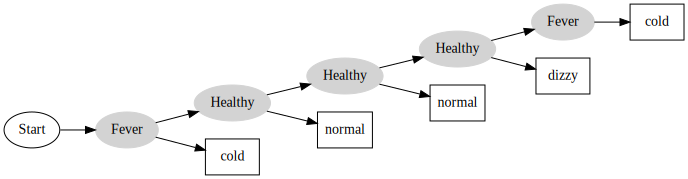

In [23]:
g = Digraph()
g.attr(rankdir='LR')

g.node("Start")
for i,sta in enumerate(states):
    g.node(str(i+1)+ "_" + sta, color='lightgray', label=sta, style='filled')
    
for i,obs in enumerate(observations):
    g.node(str(i+1)+ "_" + obs, color='black',shape="box", label=obs)

g.edge("Start",str(1) + "_" + states[0])
    
for i in range(len(states)-1):
    g.edge(str(i+1) + "_" + states[i],str(i+2) + "_" + states[i+1])
    
for i in range(len(observations)):
    g.edge(str(i+1) + "_" + states[i],str(i+1) + "_" + observations[i])
g

## viterbi 算法

In [24]:
def viterbi(trainsition_probability,emission_probability,pi,obs_seq):
    # 隐藏状态个数
    N = np.array(trainsition_probability).shape[0]     
    # 观测序列的观测个数，即时刻个数
    T = len(obs_seq)     
    # 每个时刻每个状态对应的局部最优状态序列的概率值
    delta = np.zeros((N,T))    
    # 保存每个时刻每个状态取到最大概率的前置节点
    phi = np.zeros((N,T),dtype = int)    
    #初始状态
    delta[:,0] = pi*np.transpose(emission_probability[:,obs_seq[0]])
    print("delta[:,0]",delta[:,0])
    for t in range(1,T):
        list_max=[]
        for n in range(N):
            # 计算时刻t,状态为n的所有单个路径的概率值
            delta_ti = delta[:,t-1]*np.transpose(trainsition_probability[:,n])
            print("delta_ti",delta_ti)
            # 保存最大概率
            list_max.append(np.max(delta_ti))
            print("list_max",list_max)
            # 保存最大概率对应的前置节点
            phi[n,t] = np.argmax(delta_ti)
            print("phi[%d, %d]"%(n,t), phi[n,t])    
        delta[:,t] = np.array(list_max)*np.transpose(emission_probability[:,obs_seq[t]]) 
        print("delta[:,%d]"%t,delta[:,t])
    result = np.zeros(T)
    result[T-1] = np.argmax(delta[:,T-1])
    print("result[%d]"%(T-1), result[T-1])
    for t in range(T-2,-1,-1):
        result[t] = phi[int(result[t+1]),t+1]
        print("result[%d]"%t, result[t])
    return result


In [25]:
def viterbi_with_flowchart(trainsition_probability,emission_probability,pi,states, observations,obs_seq):
    
    g = Digraph()
    g.attr(rankdir='LR')
    
    # 隐藏状态个数
    N = np.array(trainsition_probability).shape[0] 
    
    # 观测序列的观测个数，即时刻个数
    T = len(obs_seq) 
    
    # 每个时刻每个状态对应的局部最优状态序列的概率值
    delta = np.zeros((N,T))
    
    # 保存每个时刻每个状态取到最大概率的前置节点
    phi = np.zeros((N,T),dtype = int)
    
    #初始状态
    delta[:,0] = pi*np.transpose(emission_probability[:,obs_seq[0]])
    logging.debug("delta[:,0]: " + str(delta[:,0]))
    
    for index,state in enumerate(states):
        g.node(str(0) + "_" + state, label=state)
        g.edge("Start", str(0) + "_" + state)
    
    for t in range(1,T):
        logging.debug("\t 第一层for循环：t = %d"%t)
        for index,state in enumerate(states):
            g.node(str(t) + "_" + state, label=state)
        list_max=[]
        for n in range(N):
            logging.debug("\t\t 第二层for循环：n = %d"%n)
            # 计算时刻t,状态为n的所有单个路径的概率值
            delta_ti = delta[:,t-1]*np.transpose(trainsition_probability[:,n])
            logging.debug("\t\tdelta_ti: "+ str(delta_ti))
            # 保存最大概率
            list_max.append(np.max(delta_ti))
            logging.debug("\t\tlist_max: "+ str(list_max))
            # 保存最大概率对应的前置节点
            phi[n,t] = np.argmax(delta_ti)
            logging.debug("\t\tphi[%d, %d]: "%(n,t)+str(phi[n,t]))
            g.edge(str(t-1)+"_"+states[phi[n,t]], str(t) + "_" + states[n])
        delta[:,t] = np.array(list_max)*np.transpose(emission_probability[:,obs_seq[t]]) 
        logging.debug("\tdelta[:,%d]: "%t + str(delta[:,t]))

    result = np.zeros(T)
    result[T-1] = np.argmax(delta[:,T-1]) 
    g.node(str(T-1) + "_" + states[int(result[T-1])], label=states[int(result[T-1])], style='filled', color="lightgray")
    logging.debug("result[%d]: "%(T-1)+str(result[T-1]))
    for t in range(T-2,-1,-1):
        result[t] = phi[int(result[t+1]),t+1]
        logging.debug("result[%d]: "%t+str(result[t]))
        g.node(str(t) + "_" + states[int(result[t])], label=states[int(result[t])], style='filled', color="lightgray")
    return result,g


### 案例一

2021-03-30 10:13:13,303 - [line:20] - DEBUG: delta[:,0]: [0.1  0.16 0.28]
2021-03-30 10:13:13,304 - [line:27] - DEBUG: 	 第一层for循环：t = 1
2021-03-30 10:13:13,305 - [line:32] - DEBUG: 		 第二层for循环：n = 0
2021-03-30 10:13:13,305 - [line:35] - DEBUG: 		delta_ti: [0.05  0.048 0.056]
2021-03-30 10:13:13,306 - [line:38] - DEBUG: 		list_max: [0.055999999999999994]
2021-03-30 10:13:13,306 - [line:41] - DEBUG: 		phi[0, 1]: 2
2021-03-30 10:13:13,306 - [line:32] - DEBUG: 		 第二层for循环：n = 1
2021-03-30 10:13:13,307 - [line:35] - DEBUG: 		delta_ti: [0.02  0.08  0.084]
2021-03-30 10:13:13,307 - [line:38] - DEBUG: 		list_max: [0.055999999999999994, 0.08399999999999999]
2021-03-30 10:13:13,308 - [line:41] - DEBUG: 		phi[1, 1]: 2
2021-03-30 10:13:13,308 - [line:32] - DEBUG: 		 第二层for循环：n = 2
2021-03-30 10:13:13,309 - [line:35] - DEBUG: 		delta_ti: [0.03  0.032 0.14 ]
2021-03-30 10:13:13,310 - [line:38] - DEBUG: 		list_max: [0.055999999999999994, 0.08399999999999999, 0.13999999999999999]
2021-03-30 10:13:13,3

[2. 2. 2.]
观测序列： red, white, red
隐藏序列： box3, box3, box3


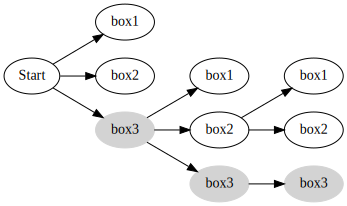

In [26]:
states = ("box1","box2","box3")
observations = ('red','white')
trainsion_probility = np.array([[0.5, 0.2, 0.3],
                                [0.3, 0.5, 0.2],
                                [0.2, 0.3, 0.5]])
emission_probility = np.array([[0.5, 0.5],
                               [0.4, 0.6],
                               [0.7, 0.3]])
pi = np.array([0.2,0.4,0.4])
obs_seq = np.array([0,1,0])

res,g = viterbi_with_flowchart(trainsion_probility, emission_probility, pi, states, observations, obs_seq)
print(res)
print("观测序列：", ", ".join(map(lambda x: observations[int(x)], obs_seq)))
print("隐藏序列：", ", ".join(map(lambda x: states[int(x)], res)))
g

### 案例2

In [27]:
states = ('Healthy', 'Fever')
start_probability = {'Healthy': 0.6, 'Fever': 0.4}
transition_probability = {
    'Healthy': {'Healthy': 0.7, 'Fever': 0.3},
    'Fever': {'Healthy': 0.4, 'Fever': 0.6},
}
emission_probability = {
    'Healthy': {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
    'Fever': {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
}
observations = ('normal', 'cold', 'dizzy')

states_label_index, states_index_label = generate_index_map(states)
observations_label_index, observations_index_label = generate_index_map(observations)

A = convert_map_to_matrix(transition_probability, states_label_index, states_label_index)
B = convert_map_to_matrix(emission_probability, states_label_index, observations_label_index)
observations_index = convert_observations_to_index(observations, observations_label_index)
pi = convert_map_to_vector(start_probability, states_label_index)

2021-03-30 10:13:13,465 - [line:20] - DEBUG: delta[:,0]: [0.3  0.04]
2021-03-30 10:13:13,466 - [line:27] - DEBUG: 	 第一层for循环：t = 1
2021-03-30 10:13:13,468 - [line:32] - DEBUG: 		 第二层for循环：n = 0
2021-03-30 10:13:13,469 - [line:35] - DEBUG: 		delta_ti: [0.21  0.016]
2021-03-30 10:13:13,470 - [line:38] - DEBUG: 		list_max: [0.21]
2021-03-30 10:13:13,470 - [line:41] - DEBUG: 		phi[0, 1]: 0
2021-03-30 10:13:13,471 - [line:32] - DEBUG: 		 第二层for循环：n = 1
2021-03-30 10:13:13,471 - [line:35] - DEBUG: 		delta_ti: [0.09  0.024]
2021-03-30 10:13:13,472 - [line:38] - DEBUG: 		list_max: [0.21, 0.09]
2021-03-30 10:13:13,472 - [line:41] - DEBUG: 		phi[1, 1]: 0
2021-03-30 10:13:13,473 - [line:44] - DEBUG: 	delta[:,1]: [0.084 0.027]
2021-03-30 10:13:13,473 - [line:27] - DEBUG: 	 第一层for循环：t = 2
2021-03-30 10:13:13,474 - [line:32] - DEBUG: 		 第二层for循环：n = 0
2021-03-30 10:13:13,474 - [line:35] - DEBUG: 		delta_ti: [0.0588 0.0108]
2021-03-30 10:13:13,475 - [line:38] - DEBUG: 		list_max: [0.0588]
2021-03-30 

观测序列： normal, cold, dizzy
隐藏序列： Healthy, Healthy, Fever


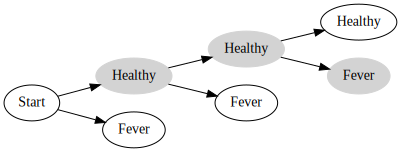

In [28]:
obs_seq = np.array([0,1,2])
#res = viterbi(A, B, pi, obs_seq)
res,g = viterbi_with_flowchart(A, B, pi, states, observations, obs_seq)
print("观测序列：", ", ".join(map(lambda x: observations[int(x)], obs_seq)))
print("隐藏序列：", ", ".join(map(lambda x: states[int(x)], res)))
g

## 结巴分词

In [5]:
# 概率值都是取对数之后的结果
from prob_start import P as start_p # 状态初始概率
from prob_trans import P as trans_p # 状态转移概率
from prob_emit import P as emit_p   # 状态发射概率

MIN_FLOAT = -3.14e100

PrevStatus = {
    'B': 'ES',
    'M': 'MB',
    'S': 'SE',
    'E': 'BM'
}

In [6]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]  # tabular
    path = {}
    for y in states:  # init
        V[0][y] = start_p[y] + emit_p[y].get(obs[0], MIN_FLOAT)
        path[y] = [y]
    print(path)
    for t in range(1, len(obs)):
        V.append({})
        newpath = {}
        for y in states:
            em_p = emit_p[y].get(obs[t], MIN_FLOAT)
            (prob, state) = max(
                [(V[t - 1][y0] + trans_p[y0].get(y, MIN_FLOAT) + em_p, y0) for y0 in PrevStatus[y]])
            V[t][y] = prob
            newpath[y] = path[state] + [y]
        path = newpath
        print(path)

    (prob, state) = max((V[len(obs) - 1][y], y) for y in 'ES')

    return (prob, path[state])

sentence = "商品和服务"
print(viterbi(sentence, "BMES", start_p, trans_p, emit_p))

{'B': ['B'], 'M': ['M'], 'E': ['E'], 'S': ['S']}
{'B': ['S', 'B'], 'M': ['B', 'M'], 'E': ['B', 'E'], 'S': ['S', 'S']}
{'B': ['B', 'E', 'B'], 'M': ['B', 'M', 'M'], 'E': ['B', 'M', 'E'], 'S': ['B', 'E', 'S']}
{'B': ['B', 'E', 'S', 'B'], 'M': ['B', 'E', 'B', 'M'], 'E': ['B', 'E', 'B', 'E'], 'S': ['B', 'E', 'S', 'S']}
{'B': ['B', 'E', 'S', 'S', 'B'], 'M': ['B', 'E', 'S', 'B', 'M'], 'E': ['B', 'E', 'S', 'B', 'E'], 'S': ['B', 'E', 'S', 'S', 'S']}
(-32.971075868389356, ['B', 'E', 'S', 'B', 'E'])


In [7]:
def __cut(sentence):
    global emit_P
    prob, pos_list = viterbi(sentence, 'BMES', start_p, trans_p, emit_p)
    begin, nexti = 0, 0
    # print pos_list, sentence
    for i, char in enumerate(sentence):
        pos = pos_list[i]
        if pos == 'B':
            begin = i
        elif pos == 'E':
            yield sentence[begin:i + 1]
            nexti = i + 1
        elif pos == 'S':
            yield char
            nexti = i + 1
    if nexti < len(sentence):
        yield sentence[nexti:]
print(list(__cut(sentence)))

{'B': ['B'], 'M': ['M'], 'E': ['E'], 'S': ['S']}
{'B': ['S', 'B'], 'M': ['B', 'M'], 'E': ['B', 'E'], 'S': ['S', 'S']}
{'B': ['B', 'E', 'B'], 'M': ['B', 'M', 'M'], 'E': ['B', 'M', 'E'], 'S': ['B', 'E', 'S']}
{'B': ['B', 'E', 'S', 'B'], 'M': ['B', 'E', 'B', 'M'], 'E': ['B', 'E', 'B', 'E'], 'S': ['B', 'E', 'S', 'S']}
{'B': ['B', 'E', 'S', 'S', 'B'], 'M': ['B', 'E', 'S', 'B', 'M'], 'E': ['B', 'E', 'S', 'B', 'E'], 'S': ['B', 'E', 'S', 'S', 'S']}
['商品', '和', '服务']


## 练习

利用MSR语料计算初始状态概率向量$\pi$,状态转移概率矩阵$A$和发射概率矩阵$B$,构建分词器并进行性能评测。